## Some imports

In [1]:
%pylab inline

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import scipy.io
import util
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
def dist(f1, f2):
    """
    distance between two frames assuming they are optimally aligned
    :param f1: frame 1
    :param f2: frame 2
    :return: the distance
    """
    return np.sum (np.power((f1 - f2).reshape((-1, 1)), 2))

In [72]:
def dist2(f1, f2):
    """
    distance between two frames assuming they are optimally aligned
    :param f1: frame 1
    :param f2: frame 2
    :return: the distance
    """
    d = 0.0
    for colIdx in range(1, lmax - 1):
        for rowIdx in range(1, lmax - 1):
            ival_1 = .0
            ival_2 = .0
            for i in range (-1, 1):
                for j in range (-1, 1):
                    ival_1 += f1[colIdx+i, rowIdx+j]
                    ival_2 += f2[colIdx+i, rowIdx+j]
            ival_1 /= 9.0
            ival_2 /= 9.0
            d += np.abs(ival_1 - ival_2)
    return d

In [68]:
def insert_rot_frame(vf, f_pad, th):
    
    f_pad.fill (0.0)
    
    sin_th = np.sin(th)
    cos_th = np.cos(th)
    
    cx = int (np.floor (0.5 * f_pad.shape[0]))
    cy = int (np.floor (0.5 * f_pad.shape[1]))
    
    xr = cos_th * vf[:, 0] - sin_th * vf[:, 1]
    yr = sin_th * vf[:, 0] + cos_th * vf[:, 1]

    for i in range(vf.shape[0]):
        ind_x = int (np.floor(xr[i]))
        ind_y = int (np.floor(yr[i]))
        
        frac_x = xr[i] - ind_x
        frac_y = yr[i] - ind_y

        #bilinear extrapolation
        f_pad[cx + ind_x    , cy - ind_y    ] += (1.0 - frac_x) * (1.0 - frac_y) * vf[i, 2]
        f_pad[cx + ind_x + 1, cy - ind_y    ] +=        frac_x  * (1.0 - frac_y) * vf[i, 2]
        f_pad[cx + ind_x    , cy - ind_y - 1] += (1.0 - frac_x) *        frac_y  * vf[i, 2]
        f_pad[cx + ind_x + 1, cy - ind_y - 1] +=        frac_x  *        frac_y  * vf[i, 2]

In [4]:
f_orig_data = '../149septinpixels.mat'
f_rotated_data = '../149septin_rotated.npy'
f_distances = '../149septin_distances.npy'
f_vector = '../149septin_vframes.npy'

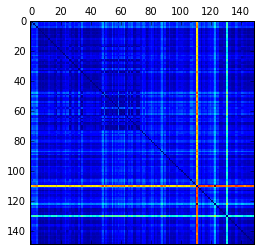

In [116]:
d_orig = np.load ('../149septin_metric.npy')
matshow(d_orig)

In [64]:
th = np.load ('../149septin_rot.npy')
        

In [84]:
vframes = np.load ('../149septin_vframes.npy')
dim = np.load ('../149septin_dim.npy')

lxmax = np.max (dim[:, 0])
lymax = np.max (dim[:, 1])

lmax = int (np.round (max (lxmax, lymax) * 1.5))
print lmax

372


In [76]:
%load_ext Cython

In [99]:
%%cython

import numpy as np
cimport numpy as np
cdef lmax = 372
cdef n_frames = 149


vframes = np.load ('../149septin_vframes.npy')
th = np.load ('../149septin_rot.npy')
d = np.zeros((n_frames, n_frames))



cdef insert_rot_frame(vf, f_pad, th):
    
    f_pad.fill (0.0)
    
    sin_th = np.sin(th)
    cos_th = np.cos(th)
    
    cx = int (np.floor (0.5 * f_pad.shape[0]))
    cy = int (np.floor (0.5 * f_pad.shape[1]))
    
    xr = cos_th * vf[:, 0] - sin_th * vf[:, 1]
    yr = sin_th * vf[:, 0] + cos_th * vf[:, 1]

    for i in range(vf.shape[0]):
        ind_x = int (np.floor(xr[i]))
        ind_y = int (np.floor(yr[i]))
        
        frac_x = xr[i] - ind_x
        frac_y = yr[i] - ind_y

        #bilinear extrapolation
        f_pad[cx + ind_x    , cy - ind_y    ] += (1.0 - frac_x) * (1.0 - frac_y) * vf[i, 2]
        f_pad[cx + ind_x + 1, cy - ind_y    ] +=        frac_x  * (1.0 - frac_y) * vf[i, 2]
        f_pad[cx + ind_x    , cy - ind_y - 1] += (1.0 - frac_x) *        frac_y  * vf[i, 2]
        f_pad[cx + ind_x + 1, cy - ind_y - 1] +=        frac_x  *        frac_y  * vf[i, 2]

cdef dist2_cython(np.ndarray f1, np.ndarray f2):
    """
    distance between two frames assuming they are optimally aligned
    :param f1: frame 1
    :param f2: frame 2
    :return: the distance
    """
    cdef d = 0.0
    cdef ival_1 = .0
    cdef ival_2 = .0
    for colIdx in range(1, lmax - 1):
        for rowIdx in range(1, lmax - 1):
            ival_1 = .0
            ival_2 = .0        
            for i in range (-1, 1):
                for j in range (-1, 1):
                    ival_1 += f1[colIdx+i, rowIdx+j]
                    ival_2 += f2[colIdx+i, rowIdx+j]
            ival_1 /= 9.0
            ival_2 /= 9.0
            if ival_1 - ival_2 >= 0:
                d += ival_1 - ival_2
            else:
                d += ival_2 - ival_1
    return d

f1 = np.zeros([lmax, lmax])
f2 = np.zeros([lmax, lmax])

for i in range (n_frames - 1):
    print float(i) / float (n_frames) * 100.0
    
    insert_rot_frame (vframes[i], f1, 0.0)

    for j in range (i + 1, n_frames):
        insert_rot_frame (vframes[j], f2, th[i, j])
    
        d[i, j] = dist2_cython (f1, f2)
        d[j, i] = d[i, j]

0.0
0.671140939597
1.34228187919
2.01342281879
2.68456375839
3.35570469799
4.02684563758
4.69798657718
5.36912751678
6.04026845638
6.71140939597
7.38255033557
8.05369127517
8.72483221477
9.39597315436
10.067114094
10.7382550336
11.4093959732
12.0805369128
12.7516778523
13.4228187919
14.0939597315
14.7651006711
15.4362416107
16.1073825503
16.7785234899
17.4496644295
18.1208053691
18.7919463087
19.4630872483
20.1342281879
20.8053691275
21.4765100671
22.1476510067
22.8187919463
23.4899328859
24.1610738255
24.8322147651
25.5033557047
26.1744966443
26.8456375839
27.5167785235
28.1879194631
28.8590604027
29.5302013423
30.2013422819
30.8724832215
31.5436241611
32.2147651007
32.8859060403
33.5570469799
34.2281879195
34.8993288591
35.5704697987
36.2416107383
36.9127516779
37.5838926174
38.255033557
38.9261744966
39.5973154362
40.2684563758
40.9395973154
41.610738255
42.2818791946
42.9530201342
43.6241610738
44.2953020134
44.966442953
45.6375838926
46.3087248322
46.9798657718
47.6510067114
48.32

In [108]:
print d

[[ 0.          0.75581623  0.64721957 ...,  0.6380764   0.58905213
   0.59918915]
 [ 0.75581623  0.          0.79760999 ...,  0.84664271  0.80576695
   0.82347758]
 [ 0.64721957  0.79760999  0.         ...,  0.58736719  0.60994842
   0.56552049]
 ..., 
 [ 0.6380764   0.84664271  0.58736719 ...,  0.          0.43467852
   0.3692628 ]
 [ 0.58905213  0.80576695  0.60994842 ...,  0.43467852  0.          0.40513789]
 [ 0.59918915  0.82347758  0.56552049 ...,  0.3692628   0.40513789  0.        ]]


(149, 149)


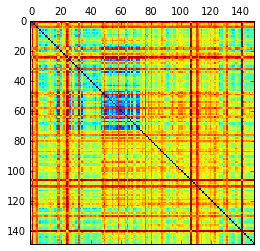

In [115]:
np.save ('../149septin_metric_interp.npy', d)
print d.shape
matshow(d)
n_frames = d.shape[0]

In [186]:
Gamma = 20.0
n_components = 2

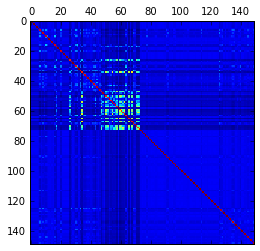

In [187]:
#K = np.exp ( -Gamma * np.sqrt(d_orig))
K = np.exp ( -Gamma * d ** 2)
one_n = np.ones((n_frames,n_frames)) / float (n_frames)

K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

matshow(K)

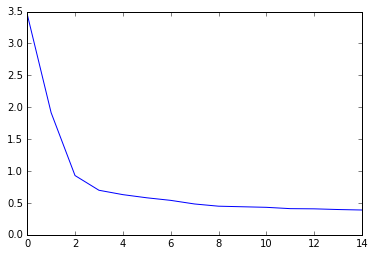

In [123]:
eig_vals, eig_vecs = np.linalg.eigh (K)

X_pc = np.column_stack((eig_vecs[:,-i] for i in range (1, n_components + 1)))

plot(range(len(eig_vals))[:15], sorted(eig_vals, reverse=True)[:15])

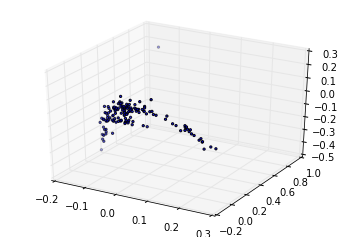

In [58]:
fig = plt.figure ()
ax = fig.add_subplot (111, projection = '3d')
ax.scatter (X_pc[:, 0], X_pc[:, 1], X_pc[:, 2], marker='.')
plt.show()

In [104]:
frames_padded = []

for vframe in vframes:
    f_padded = np.zeros ([lmax, lmax])
    
    insert_rot_frame (vframe, f_padded, 0.0)

    frames_padded.append (f_padded)

frames_padded = np.array (frames_padded).reshape(n_frames, -1)
indices = np.empty((n_frames,1), dtype=np.float32)
indices[:,0] = range(n_frames)

frames_padded = np.column_stack((frames_padded, indices))
frames_padded_shape = frames_padded.shape

In [105]:
# unique!
frames_padded_sums = [sum(x) for x in frames_padded]

def metric(X, Y):
    xi = X[frames_padded_shape[-1]-1]
    yi = Y[frames_padded_shape[-1]-1]
    
    return K[xi, yi]

In [188]:
from sklearn.decomposition import KernelPCA

pca = KernelPCA(n_components, kernel='precomputed', gamma=10)
pca.kernel = metric
res = pca.fit_transform(frames_padded)

/storage/mi/sadeghi/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [22]:
# todo: apply http://sebastianraschka.com/Articles/2014_kernel_pca.html 
# or http://www.stat.washington.edu/courses/stat539/spring14/Resources/tutorial_nonlin-dim-red.pdf

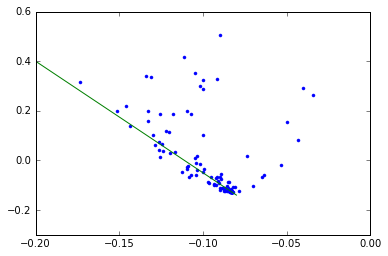

In [217]:
#ylim([-.0142, .01])
#xlim([-.07, .05])
#xlim([.05, .15])

#xlim([.0, .8])
#ylim([0, .8])
xlim([-.2, 0])

plot(res[:,0], res[:,1], marker='.', linewidth=0)
plot(np.arange(-.2, -.075, .01), -4.5*np.arange(-.2, -.075, .01)-.5)

In [218]:
lst = np.empty((0, 2))

for i in range (n_frames):
    x,y = pca.transform(frames_padded[i].reshape(1,-1))[0]
    
    # if x > -0.2 and x < 0. and y > -9.0 and y < 0.8:
    # if x >= -0.07 and x <= 0.05 and y >= -0.0142 and y <= 0.02:
    # if x >= 0.05 and x <= 0.15 and y >= -0.0142 and y <= 0.1:
    if np.abs(y - (-4.5 * x - 0.5)) < 0.01:
        lst = np.vstack((lst, np.array([i, y])))

print lst.shape
idx = np.argsort(lst[:,1])


/storage/mi/sadeghi/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(57, 2)


In [219]:
print (lst[idx[:], 0]).astype(int)

[ 32  49  25  19  64  18  58  24 130 140   1 111   4 106  76 110  22   3
  80 119 122  87   0  78 107  74  98 128  94   2 121 100  97  85  21 112
  86 108 123  81 118  88 114 105 109 120 124  84  79 132 104  96  77  90
 127  38 134]


/storage/mi/sadeghi/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/storage/mi/sadeghi/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


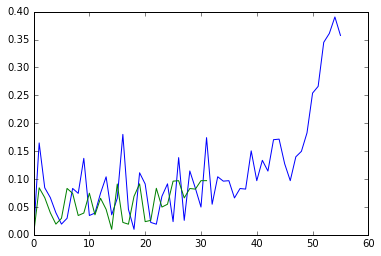

In [241]:
import pylab as pl
import time
from IPython import display

frames_movie = []
dd = []
ddd = []
f_orient = 0

for j in range (lst.shape[0]):
    
    frame_movie = np.zeros ([lmax, lmax])
    theta = 0.0
    if j > 0:
        dd.append (np.abs(d[lst[idx[f_orient].astype(int), 0], lst[idx[j].astype(int), 0]] - d[lst[idx[j-1].astype(int), 0], lst[idx[j].astype(int), 0]]))
        #theta = th [lst[idx[j - 1].astype(int), 0], lst[idx[j].astype(int), 0]]
        theta = th [lst[idx[f_orient].astype(int), 0], lst[idx[j].astype(int), 0]]
        #if np.abs(d[lst[idx[f_orient].astype(int), 0], lst[idx[j].astype(int), 0]] - d[lst[idx[j-1].astype(int), 0], lst[idx[j].astype(int), 0]]) > .1:
        #    f_orient = j
    if len(dd) == 0 or dd[-1] < .1:
        if len(dd) > 0:
            ddd.append(dd[-1])
        img = vframes[int ( lst[idx[j], 0])]
    
    insert_rot_frame (img, frame_movie, theta)
    
    frames_movie.append (frame_movie)
    
plot (dd)
plot(ddd)

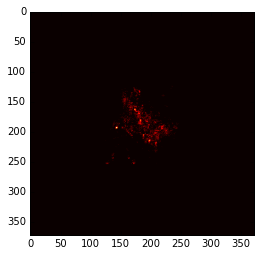

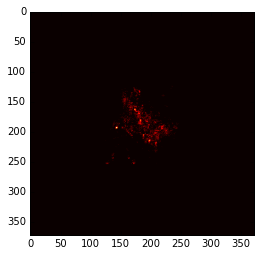

In [243]:
for img in frames_movie:
    plt.imshow (img, cmap = plt.get_cmap('hot'))

    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(.1)

In [17]:

print frames_padded.shape

#pca.transform(frames_padded)

(149, 138384)


In [18]:
res[:2] - pca.transform(frames_padded[:2])

array([[ -1.38777878e-17,  -3.46944695e-18],
       [ -1.52655666e-16,  -1.73472348e-17]])